# Tuning Tamura surface fluxes
## Diagnosing model result without tuning
The starting point is defined by the raw Tamura 2008 daily surface net heat and surface freshwater fluxes and daily surface stresses derived from EraInterim winds. This setup results in the following stratification.

In [3]:
#import bunch of packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
from visualization.plot_vslice import plot_vslice
%aimport visualization.plot_vslice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Year 5 annual averaged temperature and salinity stratification through Weddell Sea and FRIS compared to initial stratification

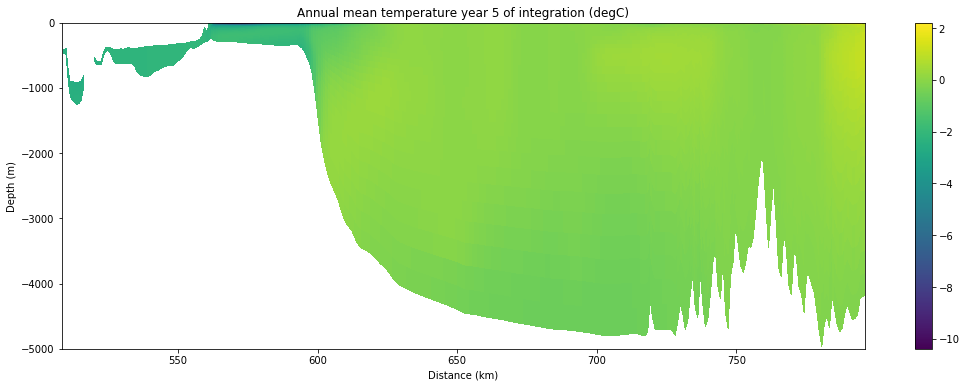

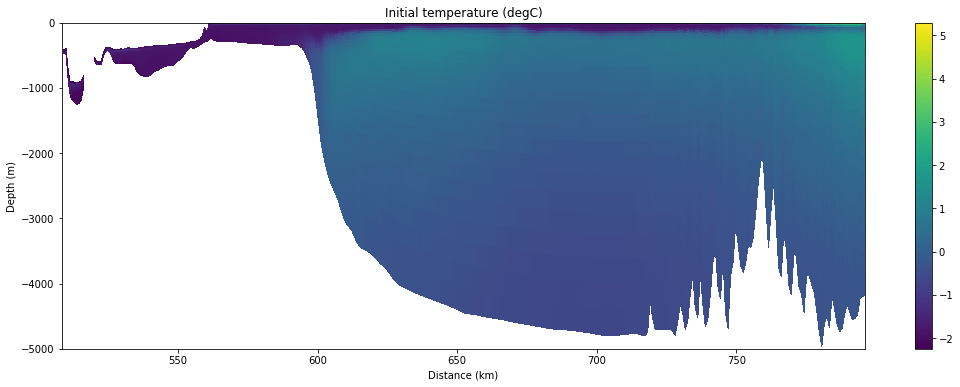

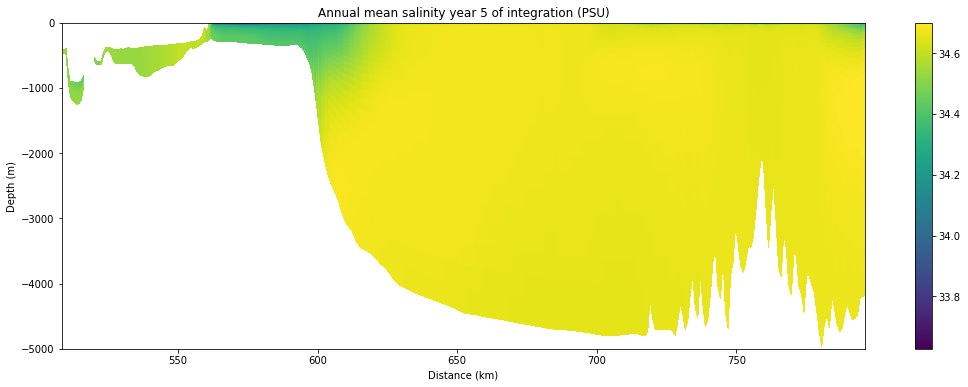

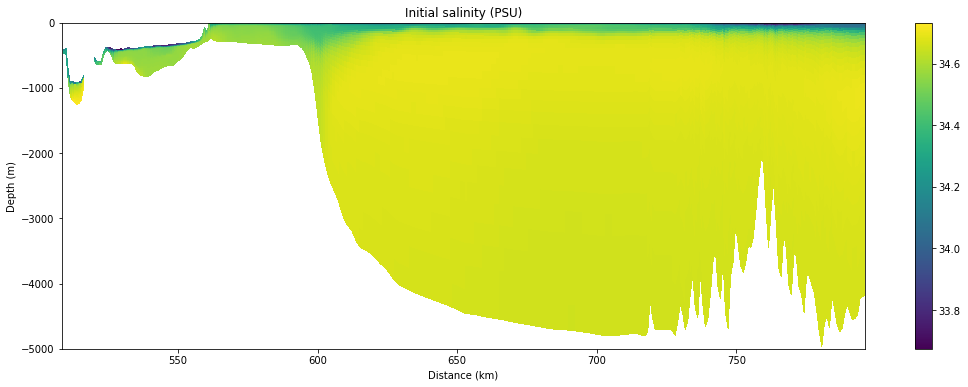

In [4]:
raw_dir = os.path.join(os.environ.get('projdir'),'data','analysis','raw')
avg_5yr_file =  os.path.join(raw_dir,'waom10_full_forcing','ocean_avg_0005.nc')
his_1yr_file = os.path.join(raw_dir,'waom10_full_forcing','ocean_avg_0001.nc')
i_min, j_min, i_max, j_max = [320,395,320,729]
plt.clf()
plot_vslice(avg_5yr_file,'temp',0,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,-1,title_str='Annual mean temperature year 5 of integration (degC)')
plot_vslice(his_1yr_file,'temp',0,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,title_str='Initial temperature (degC)')

plot_vslice(avg_5yr_file,'salt',0,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,-1,title_str='Annual mean salinity year 5 of integration (PSU)')
plot_vslice(his_1yr_file,'salt',0,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,title_str='Initial salinity (PSU)')

... we get temperatures way below the surface freezing point at the ice shelf front (see also basic diagnostics sst widget). This is likely because there is no coupling between the ocean and the heat flux forcing. E.g. the heat flux is allowed to take heat out of the ocean, even if the sea surface temperature is already at the freezing temperature.

### Snapshot temperature and salinity stratification (colorbar bounds preset) at the end of melt season (Feb)

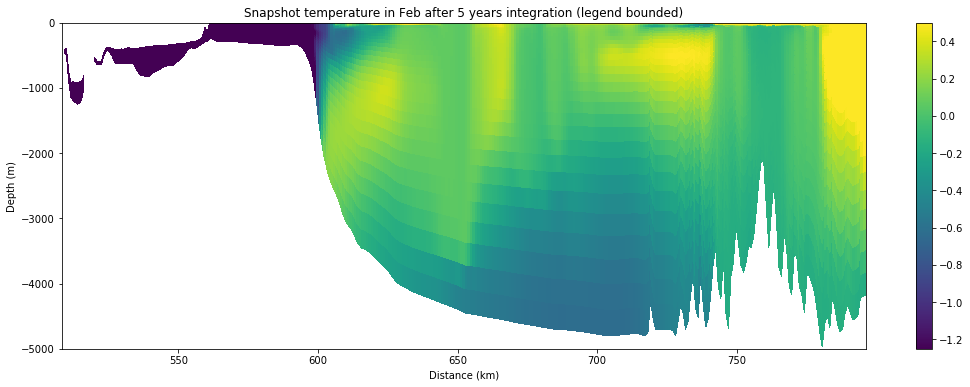

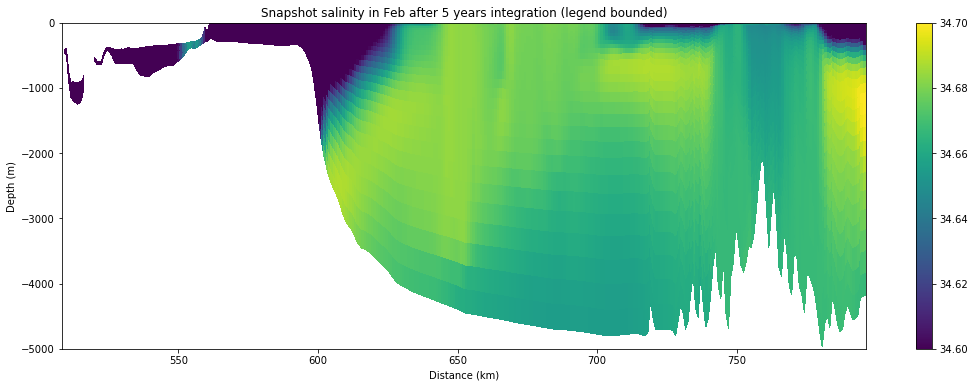

In [74]:
his_5yr_file =  os.path.join(raw_dir,'waom10_full_forcing','ocean_his_0005.nc')
plot_vslice(his_5yr_file,'temp',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=-1.25,vmax=0.5,title_str='Snapshot temperature in Feb after 5 years integration (legend bounded)')
plot_vslice(his_5yr_file,'salt',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=34.6,vmax=34.7,title_str='Snapshot salinity in Feb after 5 years integration (legend bounded)')

... also, there is a lot of mixing in the open ocean, possibly due to deep convection events driven by salt. Salt might be the driving force since salt values continue right to the surface while temperature values seem to differ between surface and interior water column. Roms is to salty compared to sose at the surface (see basic diagnostics notebook sss comparison).
Over rough topography, the mixing might be due to tides.
The stratification along the northern boundary is a good refrence for the wanted wanted interior one.
## Effect of sst relaxation
The modifications are twofold.
1. if sst goes below the freezing point, surface net heat flux is relaxed towards the freezing point
2. In summer (Nov, Dec, Jan, Feb; Takeshi melt season) we relax surface net heat flux to SOSE SST with a sensitifity of -40 W/m^2/K (more or less random, order of magnitude from Barnier 1995).

### Effect on annual average temperature stratification

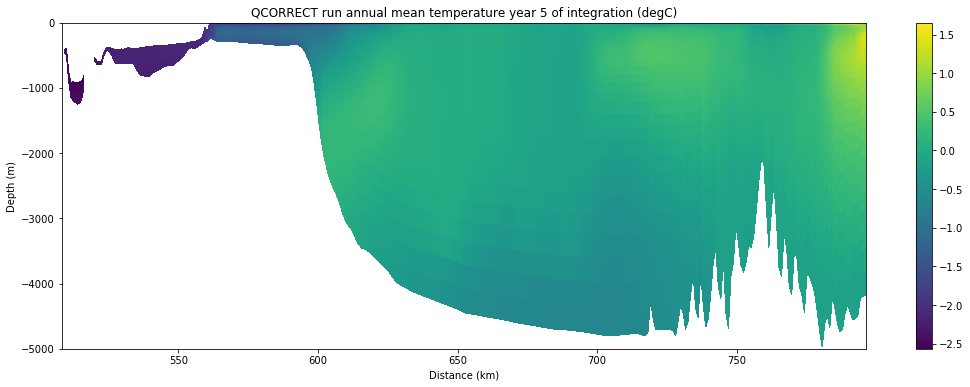

In [77]:
avg_5yr_QCORR_file = os.path.join(raw_dir,'waom10_QCORRECT','ocean_avg_0005.nc')
#plot_vslice(avg_5yr_file,'temp',0,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,-1,title_str='Reference run annual mean temperature year 5 of integration (degC)')
plot_vslice(avg_5yr_QCORR_file,'temp',0,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,-1,title_str='QCORRECT run annual mean temperature year 5 of integration (degC)')

... temperatures looks already way better! The coldes values are -2.5 now and found at the grounding line. SST at the ice front is about at surface freezing point (-1.9 degC). The ocean is still to mixed in the interior.

## Effect of deactivating tides
Simply by dactivating tides we expect a more stratified ocean.

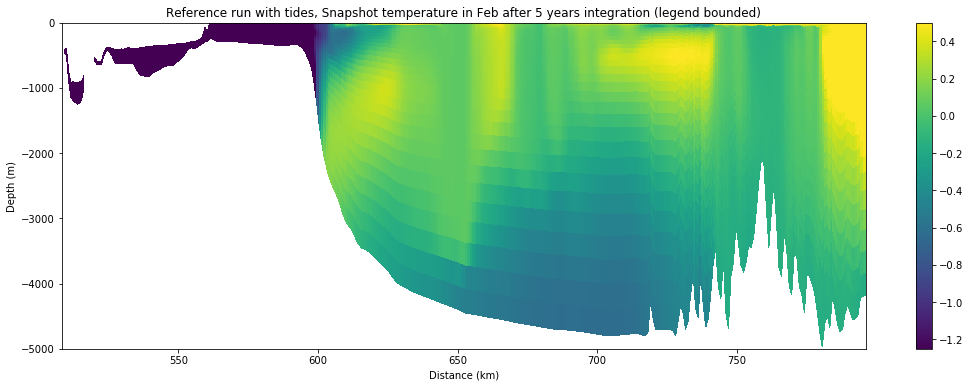

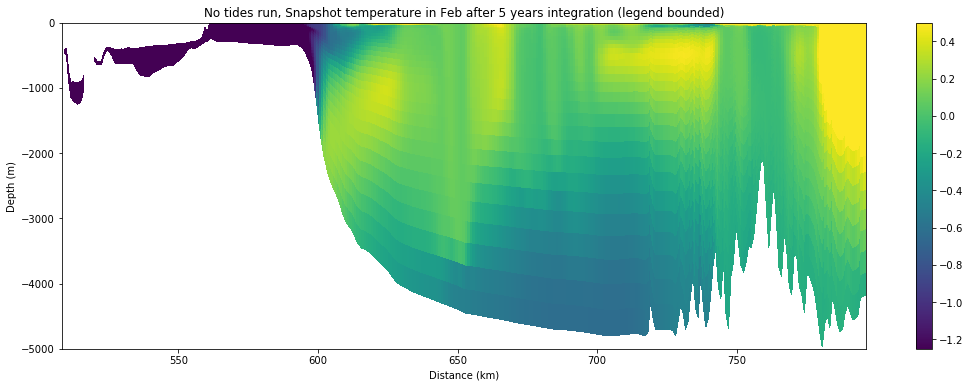

In [78]:
his_5yr_NT_file = os.path.join(raw_dir,'waom10_NT','ocean_his_0005.nc')
plot_vslice(his_5yr_file,'temp',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=-1.25,vmax=0.5,title_str='Reference run with tides, Snapshot temperature in Feb after 5 years integration (legend bounded)')
plot_vslice(his_5yr_NT_file,'temp',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=-1.25,vmax=0.5,title_str='No tides run, Snapshot temperature in Feb after 5 years integration (legend bounded)')

... turning off tides doesn't make much of a difference. The ocean seems just slightly more stratified.

## The effect of surface salt input tuning
Two modifications have been applied on top of the heat flux correction:
1. Sea surface salt flux gets relaxed to SSS from SOSE. The relaxation time scale is 3 days (Hard! Kaitlin uses 30 days) and the the nudging happens all year round.
2. Salt flux is set to zero if the ocean loses heat (winter), but is not close to the freezing point. This was implemented to avoid salt input in warm water (Takeshi says its a polynya, but roms is not yet at freezing point). CAUTION, this will most likey mess up Takeshis annual salt balance. Maybe the ocean is freshening in longer integrations now, maybe SOSE flux correction will balance this though.  

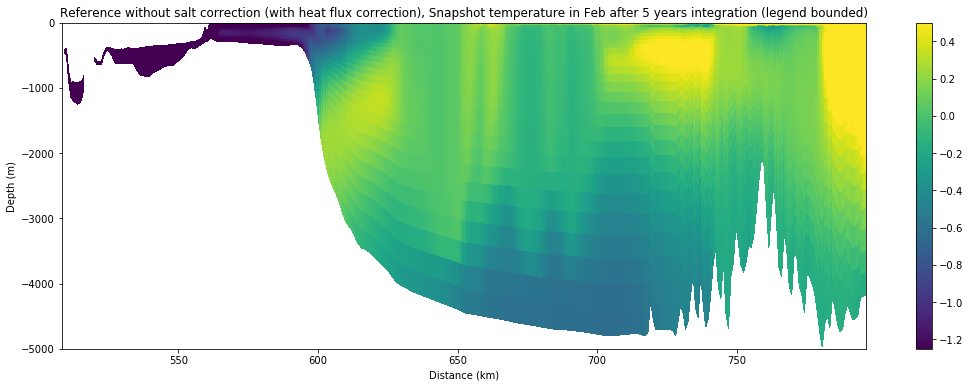

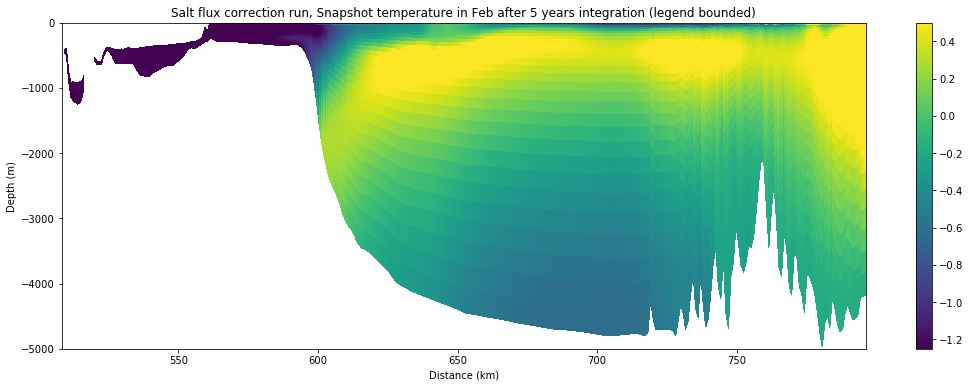

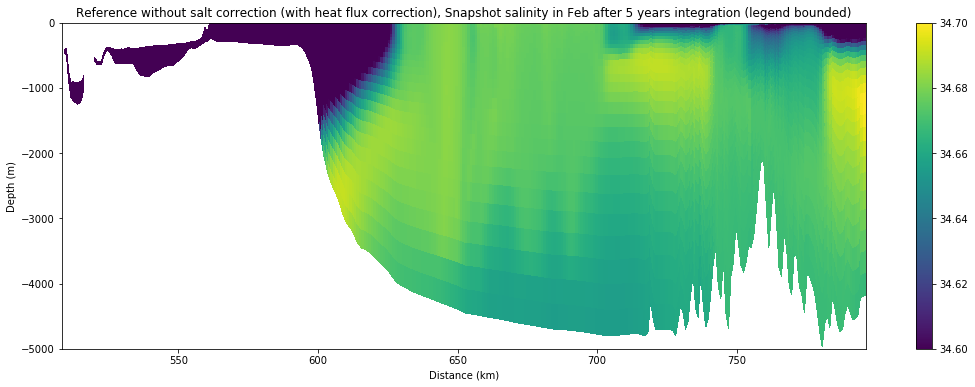

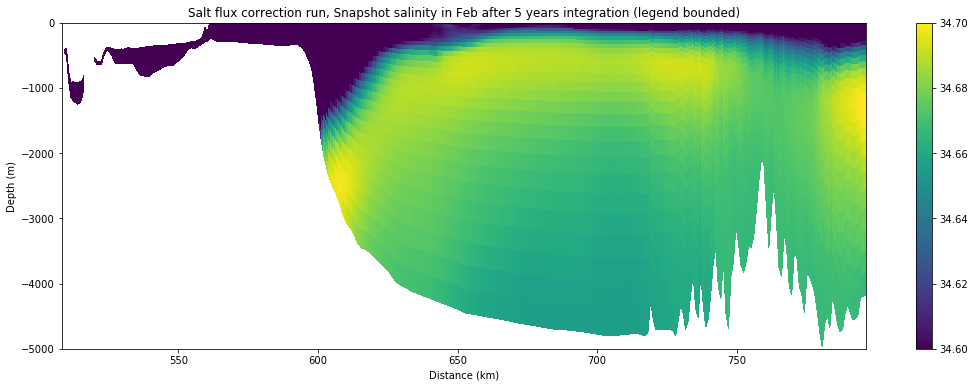

In [81]:
his_5yr_SCORR_file = os.path.join(raw_dir,'waom10_SCORRECT','ocean_his_0005.nc')
plot_vslice(his_5yr_QCORR_file,'temp',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=-1.25,vmax=0.5,title_str='Reference without salt correction (with heat flux correction), Snapshot temperature in Feb after 5 years integration (legend bounded)')
plot_vslice(his_5yr_SCORR_file,'temp',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=-1.25,vmax=0.5,title_str='Salt flux correction run, Snapshot temperature in Feb after 5 years integration (legend bounded)')
plot_vslice(his_5yr_QCORR_file,'salt',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=34.6,vmax=34.7,title_str='Reference without salt correction (with heat flux correction), Snapshot salinity in Feb after 5 years integration (legend bounded)')
plot_vslice(his_5yr_SCORR_file,'salt',1,-5000,0,i_min,j_min,i_max,j_max,4,4,0.9,50,31,vmin=34.6,vmax=34.7,title_str='Salt flux correction run, Snapshot salinity in Feb after 5 years integration (legend bounded)')

... this looks a lot better! I most likely need some sort of heat and salt flux correction. Lets have a look at the shelf ocean.

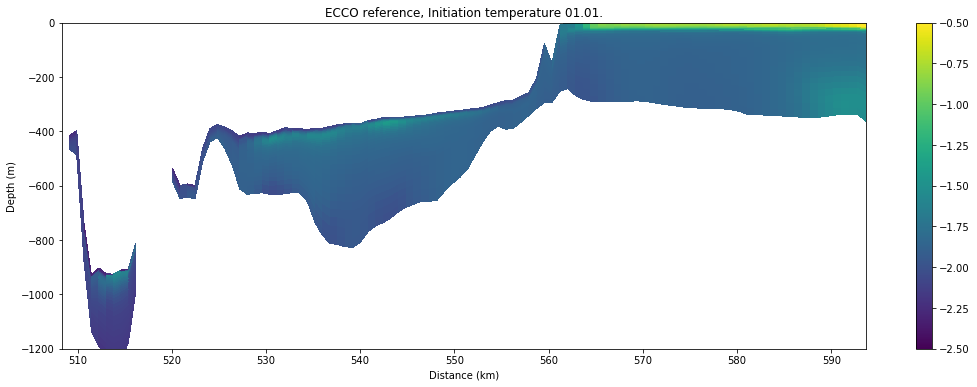

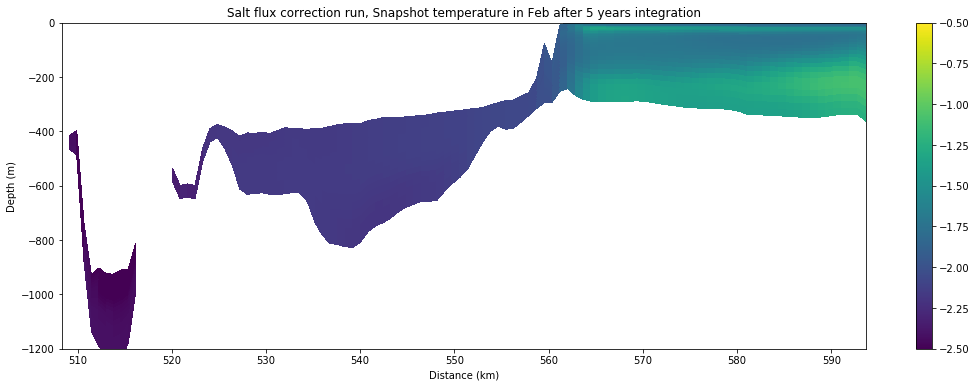

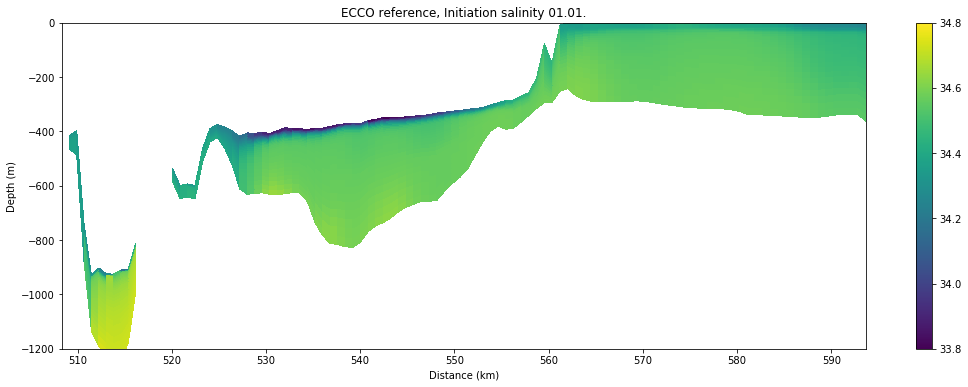

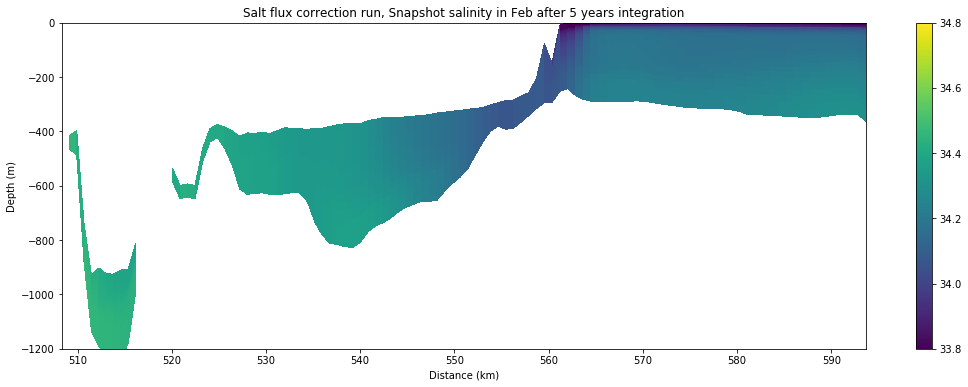

In [322]:
plot_vslice(his_1yr_file,'temp',1,-1200,0,i_min,j_min,i_max,500,4,4,0.9,50,31,vmin=-2.5,vmax=-0.5,title_str='ECCO reference, Initiation temperature 01.01.')
plot_vslice(his_5yr_SCORR_file,'temp',1,-1200,0,i_min,j_min,i_max,500,4,4,0.9,50,31,vmin=-2.5,vmax=-0.5,title_str='Salt flux correction run, Snapshot temperature in Feb after 5 years integration')
plot_vslice(his_1yr_file,'salt',1,-1200,0,i_min,j_min,i_max,500,4,4,0.9,50,31,vmin=33.8,vmax=34.8,title_str='ECCO reference, Initiation salinity 01.01.')
plot_vslice(his_5yr_SCORR_file,'salt',1,-1200,0,i_min,j_min,i_max,500,4,4,0.9,50,31,vmin=33.8,vmax=34.8,title_str='Salt flux correction run, Snapshot salinity in Feb after 5 years integration')

## Applying heat and salt flux correction just north of sea ice extend
Implemented as time varying mask. Avtive Dec-May: lat > -60 deg; Jun-Nov lat > -65 deg

In [5]:
# import my functions
import features.roms_ds as roms_ds
%aimport features.roms_ds

In [7]:
#load roms_data
roms_data_path = os.path.join(raw_dir,'waom10_latmask_QD','ocean_avg_0005.nc')
roms_ds = roms_ds.make_roms_ds(roms_data_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


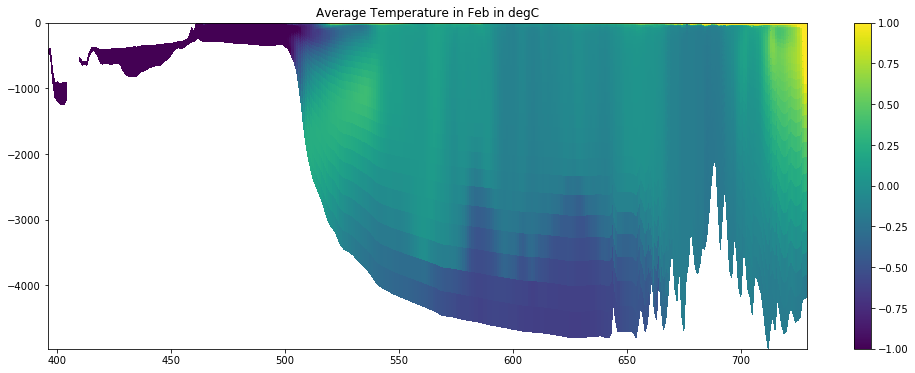

In [297]:
plt.clf()
#roms_ds.temp[0,:,300,:].plot.pcolormesh(x='xi_3d',y='depth',vmin=-1,vmax=1)
da = roms_ds.temp[1,:,395:,320]
val = da.to_masked_array()
x = da.eta_3d.to_masked_array()
y = da.depth.to_masked_array()
fig = plt.figure(figsize=(17,6))
plt.pcolormesh(x,y,val,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Average Temperature in Feb in degC')
plt.show()

... does not work! Salinity restoring all year round seems to be important.
# Evaluation of best case (salt all year, heat in summer)
## Stratification in deep ocean: annual mean salt and temperature fields along longitiude transsects compared against SOSE

In [10]:
# Generate ROMS and SOSE Xarray datasets
import xarray as xr

# import my functions
import features.roms_ds as roms_ds
%aimport features.roms_ds
import features.sose_ds as sose_ds
%aimport features.sose_ds

In [11]:
#load roms_data
roms_data_path = os.path.join(os.environ.get('rawdir'),'waom10_SCORRECT','ocean_avg_0005.nc')
rds = roms_ds.make_roms_ds(roms_data_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


In [13]:
#load sose_data
sds = sose_ds.make_TS_ds(records=np.arange(0,12))

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


In [ ]:
#define function that generates a sose vs roms longitude transsect as monthly widget or annual meandefine function that generates a sose vs roms longitude transsect as monthly widget or annual mean
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm

def plot_lont(sds,rds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,:,ind]
    rsalt_tr = rsalt_flat[:,:,ind]
    x=rtemp_tr[0].lat_rho.to_masked_array()
    y=rtemp_tr[0].depth.to_masked_array()
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('generate widget including sose plotting')
    plt.close()
    
    if mean==False:
        def plot(month):
            fig,axes = plt.subplots(2,2,figsize=(15,12))
            (ax1,ax2,ax3,ax4) = axes.flatten()

            sds.temperature.sel(longitude=slon,latitude=lats,method='nearest')[month].plot(ax=ax1,x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            ax1.set_title('SOSE')
            sds.salinity.sel(longitude=slon,latitude=lats,method='nearest')[month].plot(ax=ax3,x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline)
            ax3.set_title('SOSE')

            temp_plt = ax2.pcolormesh(x,y,rtemp_val[month],vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            plt.colorbar(temp_plt,ax=ax2,label='temperature')
            ax2.set_title('ROMS')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')

            salt_plt = ax4.pcolormesh(x,y,rsalt_val[month],vmin=smin,vmax=smax,cmap=ocm.haline)
            plt.colorbar(salt_plt,ax=ax4,label='salinity')
            ax4.set_title('ROMS')
            ax4.set_xlabel('latitude')
            ax4.set_ylabel('depth')

            if max_depth != None:
                for ax in [ax1,ax2,ax3,ax4]:
                    ax.set_ylim([-max_depth,0])

            plt.show()

        interact(plot,month=(0,11))
        
    elif mean == True:
        
        fig,axes = plt.subplots(2,2,figsize=(15,12))
        (ax1,ax2,ax3,ax4) = axes.flatten()

        sds.temperature.sel(longitude=slon,latitude=lats,method='nearest').mean('time').plot(ax=ax1,x='latitude',y='depth',vmin=tmin,vmax=tmax)
        ax1.set_title('SOSE')
        sds.salinity.sel(longitude=slon,latitude=lats,method='nearest').mean('time').plot(ax=ax3,x='latitude',y='depth',vmin=smin,vmax=smax)
        ax3.set_title('SOSE')

        temp_plt = ax2.pcolormesh(x,y,np.mean(rtemp_val,axis=0),vmin=tmin,vmax=tmax)
        plt.colorbar(temp_plt,ax=ax2,label='temperature')
        ax2.set_title('ROMS')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        salt_plt = ax4.pcolormesh(x,y,np.mean(rsalt_val,axis=0),vmin=smin,vmax=smax)
        plt.colorbar(salt_plt,ax=ax4,label='salinity')
        ax4.set_title('ROMS')
        ax4.set_xlabel('latitude')
        ax4.set_ylabel('depth')
        
        if max_depth != None:
            for ax in [ax1,ax2,ax3,ax4]:
                ax.set_ylim([-max_depth,0])

        plt.show()

### Weddell sea at longitude 45 deg W

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


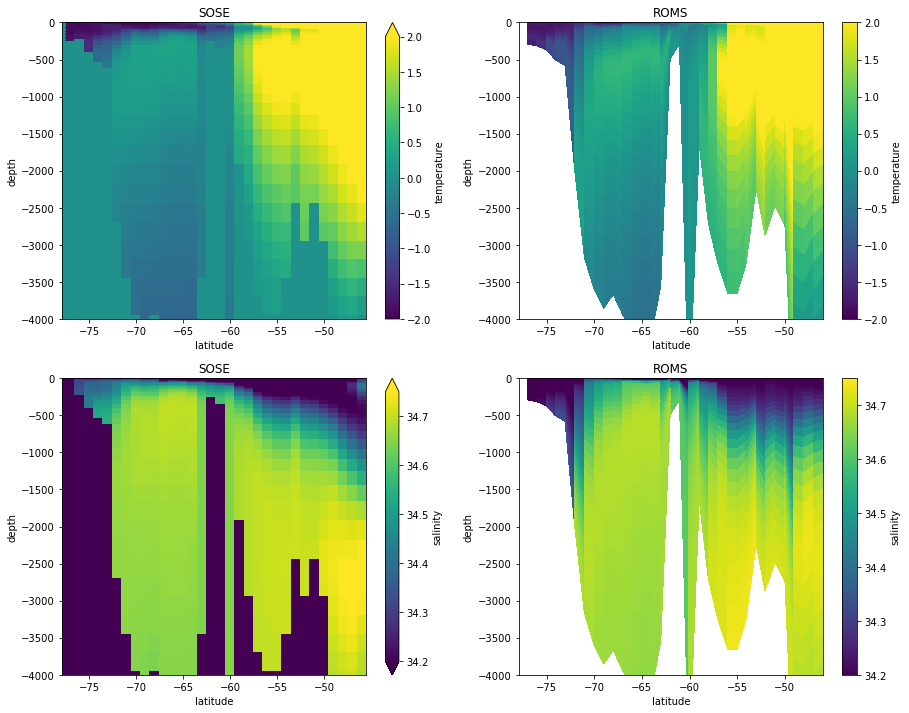

In [689]:
plot_lont(sds,rds,-45,np.arange(-80,-45),tmin=-2,tmax=2,smin=34.2,smax=34.75,max_depth=4000)

### Ross sea at longitude 180

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


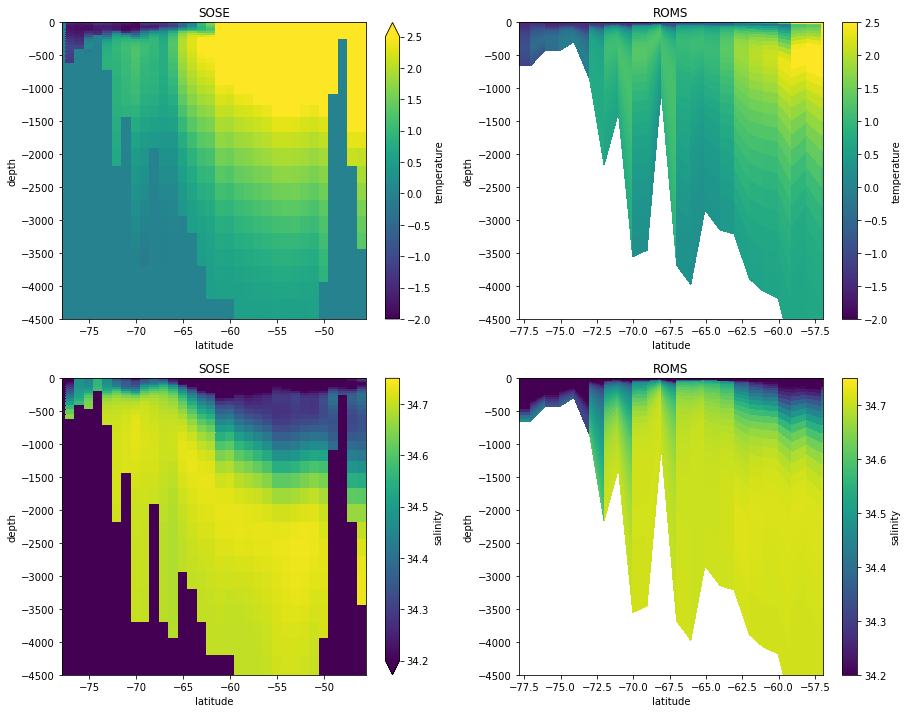

In [533]:
plot_lont(sds,rds,180,np.arange(-89,-45),tmin=-2,tmax=2.5,smin=34.2,smax=34.75,max_depth=4500)

### Bellinghausen Sea and Drake Passage at longitude 75 W

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


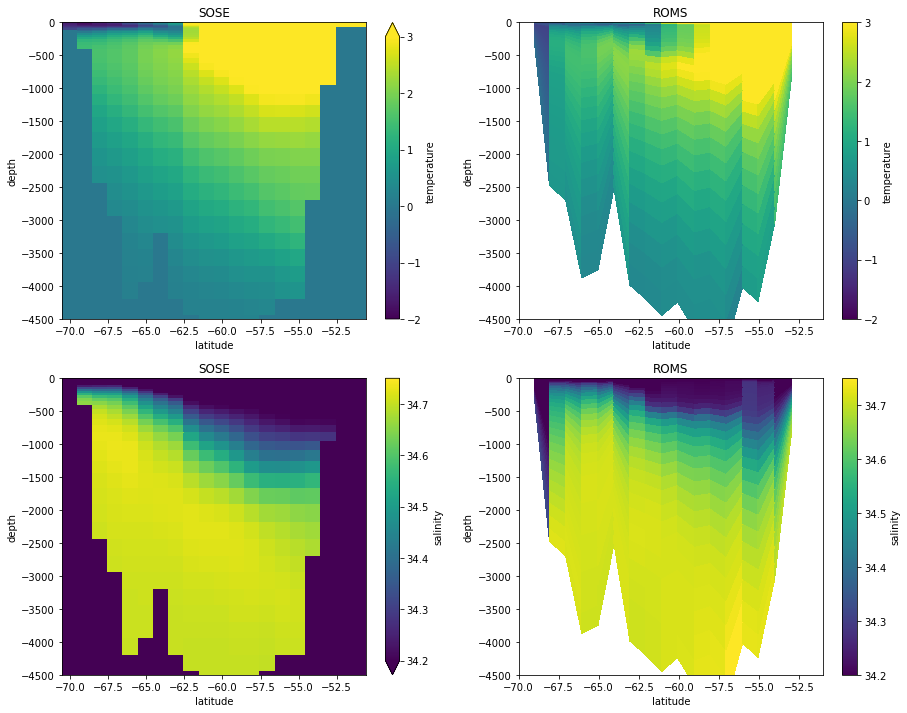

In [536]:
plot_lont(sds,rds,-75,np.arange(-70,-50),tmin=-2,tmax=3,smin=34.2,smax=34.75,max_depth=4500)

### Davis sea longitude 70 deg E

lookup nearest neighbors from roms
define axes and values from roms
generate widget including sose plotting


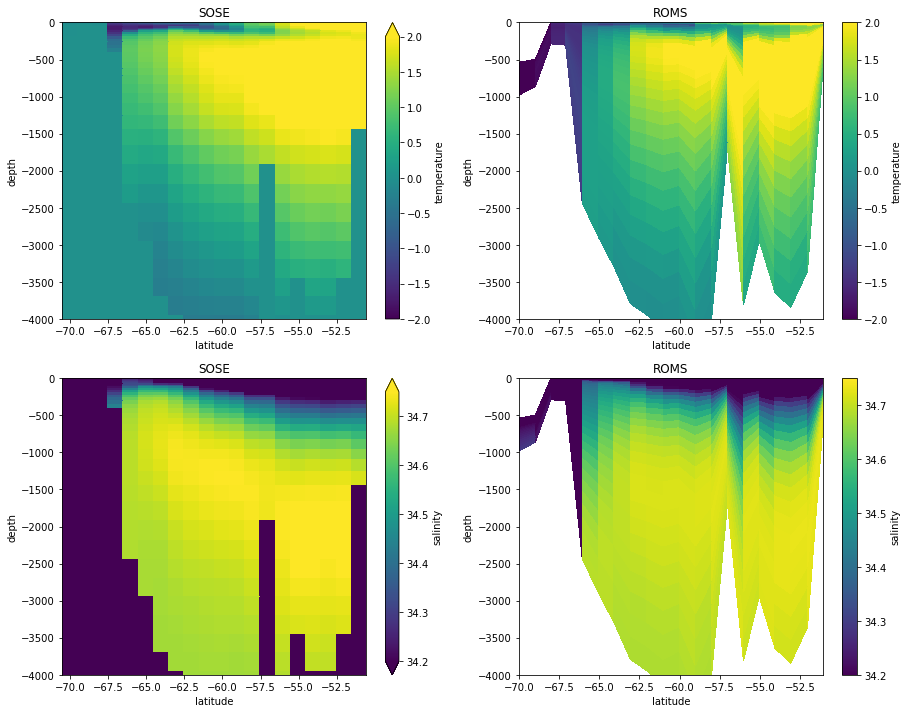

In [534]:
plot_lont(sds,rds,70,np.arange(-70,-50),tmin=-2,tmax=2,smin=34.2,smax=34.75,max_depth=4000)

## On shelf stratification: Annual averges compared against SOSE
### Defining the transsects and plotting function

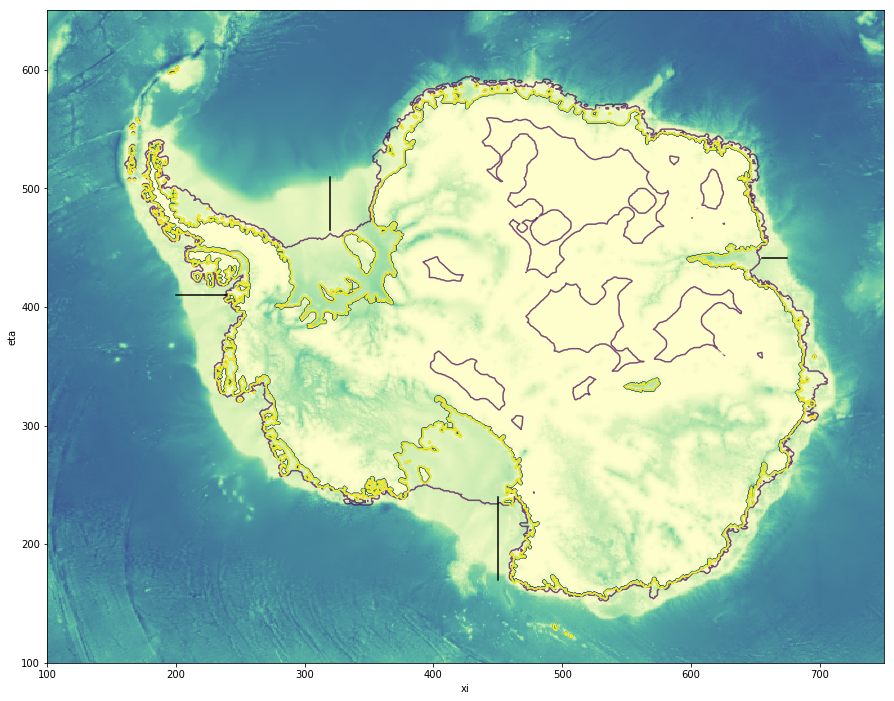

In [14]:
import cmocean.cm as cmo
import matplotlib.pyplot as plt

plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=cmo.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
davis=[655,441,675,441,"amery"]
ross=[450,170,450,240,"ross"]
weddell=[320,465,320,510,"weddel"]
amundsen=[200,410,240,410,"bellinghausen"]

for line in [davis,ross,weddell,amundsen]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

plt.xlim((100,750))
plt.ylim((100,650))
plt.show()

In [15]:
def compare_onshore(rds,sds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))

    x = rds_tr.lat_rho.to_masked_array().squeeze()
    y = rds_tr.depth[0].to_masked_array().squeeze()
    
    lons = rds_tr.lon_rho.to_masked_array().squeeze()
    lons[lons<0]+=360.0
    lats = rds_tr.lat_rho.to_masked_array().squeeze()
    
    lon_da = xr.DataArray(lons,dims='latitude')
    lat_da = xr.DataArray(lats,dims='latitude')
    
    print('calculate mean')
    temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
    salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()
    
    print('plot')
    plt.close()
    
    fig,axes = plt.subplots(2,2,figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    
    temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    plt.colorbar(temp_plt,ax=ax1,label='Temperature in deg C')
    ax1.set_title('ROMS')
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('depth')

    sds.temperature.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax2,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    ax2.set_title('SOSE')

    salt_plt = ax3.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =ocm.haline)
    plt.colorbar(salt_plt,ax=ax3,label='Salinity in PSU')
    ax3.set_title('ROMS')
    ax3.set_xlabel('latitude')
    ax3.set_ylabel('depth')

    sds.salinity.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax4,vmin=smin,vmax=smax,cmap=ocm.haline)
    ax4.set_title('SOSE')

    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    
    plt.show()        

### Davis sea

In [14]:
compare_onshore(rds,sds,davis,tmin=-2.0,tmax=0.5,smin=33.8,smax=34.6,max_depth=800)

NameError: name 'compare_onshore' is not defined

### Weddell sea

define slice
calculate mean
plot


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:1466: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  axis = [operator.index(axis)]


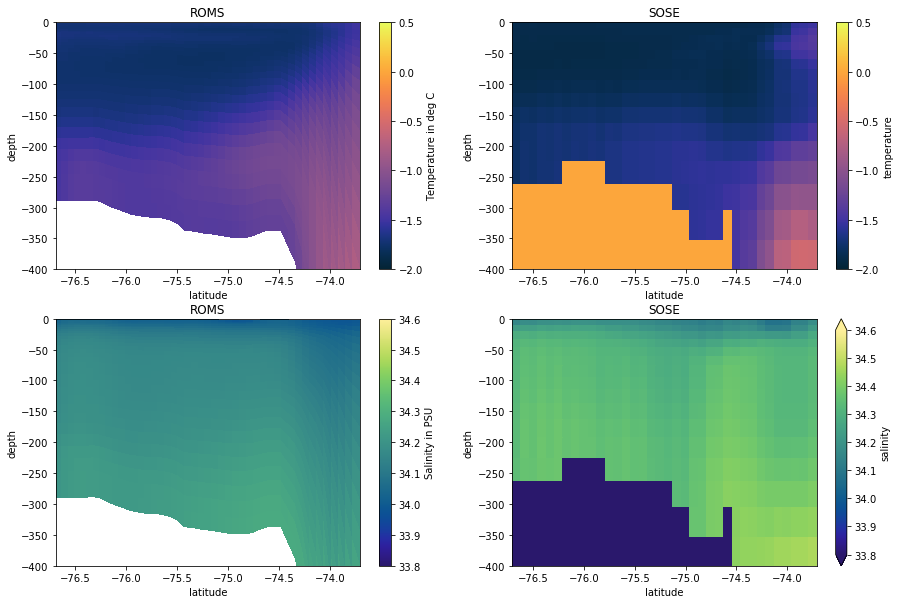

In [794]:
compare_onshore(rds,sds,weddell,tmin=-2.0,tmax=0.5,smin=33.8,smax=34.6,max_depth=400)

### Amundsen sea

define slice
calculate mean
plot


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:1466: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  axis = [operator.index(axis)]


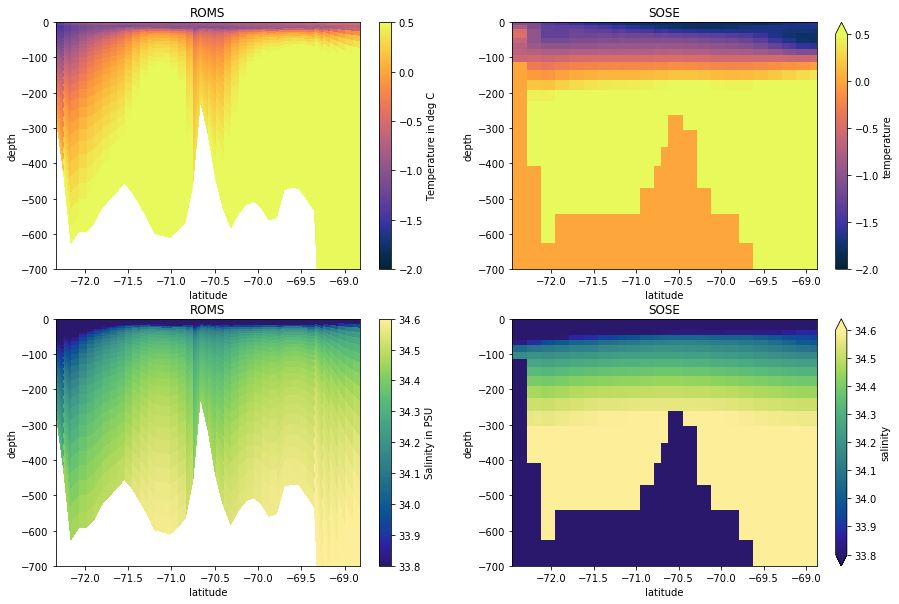

In [793]:
compare_onshore(rds,sds,amundsen,tmin=-2.0,tmax=0.5,smin=33.8,smax=34.6,max_depth=700)

### Ross sea

define slice
calculate mean
plot


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:1466: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  axis = [operator.index(axis)]


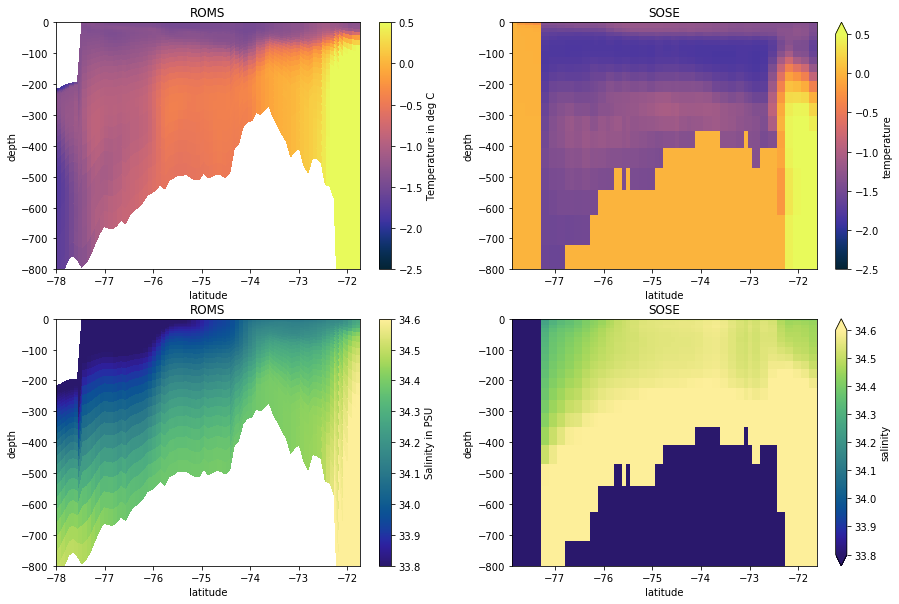

In [787]:
compare_onshore(rds,sds,ross,tmin=-2.0,tmax=0.5,smin=33.8,smax=34.6,max_depth=800)

## Under Ice shelf stratification: Monthly averages ROMS alone
### Defining transsects and plotting function 

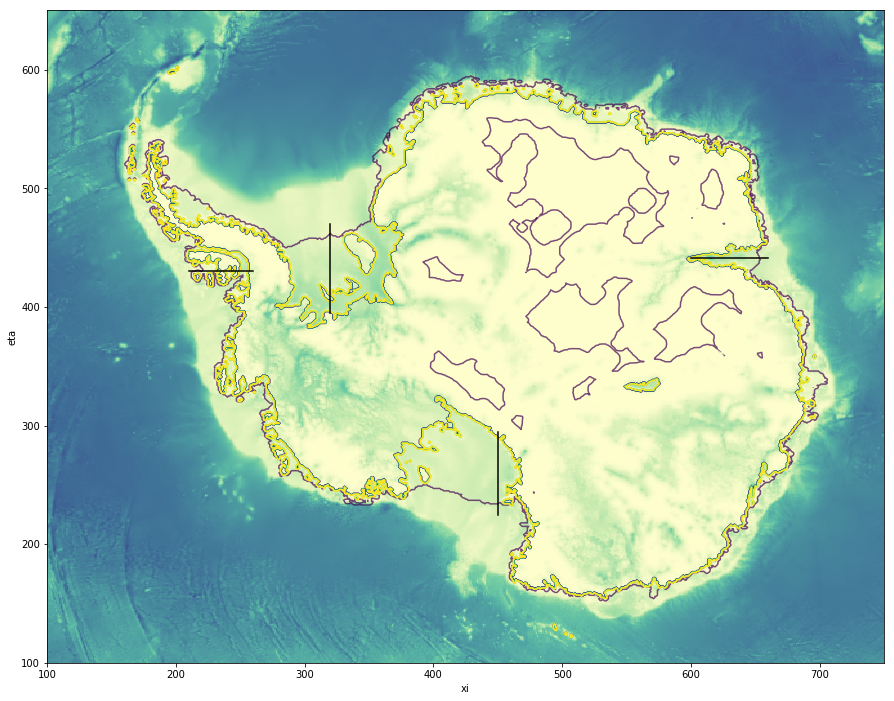

In [17]:
import cmocean.cm as cmo

plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=cmo.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
amery=[600,441,660,441,"amery"]
ross=[450,225,450,295,"ross"]
weddell=[320,395,320,470,"weddel"]
bellinghausen=[210,430,260,430,"bellinghausen"]

for line in [amery,ross,weddell,bellinghausen]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

plt.xlim((100,750))
plt.ylim((100,650))
plt.show()

In [18]:
def plot_cavity(rds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    plt.close()

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))

    x = rds_tr.lat_rho.to_masked_array().squeeze()
    y = rds_tr.depth[0].to_masked_array().squeeze()
    
    if mean == True:
        
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))
        
        print('calculate mean')
        temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
        salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()

        print('plot')
        temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
        plt.colorbar(temp_plt,ax=ax1,label='deg C')
        ax1.set_title('Temperature')
        ax1.set_ylabel('depth')

        salt_plt = ax2.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =ocm.haline)
        plt.colorbar(salt_plt,ax=ax2,label='PSU')
        ax2.set_title('Salinity')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        if max_depth != None:
            for ax in [ax1,ax2]:
                ax.set_ylim([-max_depth,0])
        
        plt.show()
        
    elif mean == False:
        
        print('set up widget')
        def widget(month):
            
            fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))

            temp_val = rds_tr.temp.to_masked_array().squeeze()
            salt_val = rds_tr.salt.to_masked_array().squeeze()

            temp_plt = ax1.pcolormesh(x,y,temp_val[month],vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            plt.colorbar(temp_plt,ax=ax1,label='deg C')
            ax1.set_title('Temperature')
            ax1.set_ylabel('depth')

            salt_plt = ax2.pcolormesh(x,y,salt_val[month],vmin=smin,vmax=smax,cmap =ocm.haline)
            plt.colorbar(salt_plt,ax=ax2,label='PSU')
            ax2.set_title('Salinity')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')
            
            if max_depth != None:
                for ax in [ax1,ax2]:
                    ax.set_ylim([-max_depth,0])
            
            plt.show()
            
        interact(widget,month=(0,11))

### Amery ice shelf cavity

In [19]:
plot_cavity(rds,amery,tmin=-2.5,tmax=0.5,smin=33.8,smax=34.6,mean=False,max_depth=2500)

define slice
set up widget


NameError: name 'interact' is not defined

### Ronne Flichner cavity

In [ ]:
plot_cavity(rds,weddell,tmin=-2.5,tmax=0.5,smin=33.8,smax=34.6,mean=False,max_depth=1300)

### Ross ice shelf cavity and sea

In [ ]:
plot_cavity(rds,ross,tmin=-2.5,tmax=0.5,smin=33.8,smax=34.6,mean=False,max_depth=900)

### Bellinghausen ice shelves and sea

In [ ]:
plot_cavity(rds,bellinghausen,tmin=-2.5,tmax=0.5,smin=33.8,smax=34.6,mean=False,max_depth=800)